# Option Skew Plots, Normalized

In [1]:
from pathlib import Path
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from IPython.display import display
from datetime import timedelta

plt.style.use('seaborn-v0_8')

VALUATION_DATE = pd.Timestamp("2025-10-13")
chain_path =  '../data/VIX_65d_Options_ChainData.csv'
underlying_path =  '../data/VIX_65d_Options_UnderlyingData.csv'

chain = pd.read_csv(chain_path)
# Normalise the chain columns by removing excess whitespace and internal spaces.
chain.columns = (
    chain.columns
    .str.strip()
    .str.replace(r"\s+", "", regex=True)
)

chain['CallMid'] = (chain['CallBid'] + chain['CallAsk']) / 2
chain['PutMid'] = (chain['PutBid'] + chain['PutAsk']) / 2

required_columns = {
    'Strike', 'CallBid', 'CallAsk', 'PutBid', 'PutAsk', 'CallIVM', 'PutIVM'
}
# Accept either Expiry or T for the maturity representation.
if {'Expiry', 'T'} & set(chain.columns):
    required_columns.add('Expiry' if 'Expiry' in chain.columns else 'T')
else:
    raise ValueError('Missing required maturity column: expected `Expiry` or `T`.')

missing_columns = sorted(required_columns - set(chain.columns))
if missing_columns:
    raise ValueError(f'Missing required columns after renaming: {missing_columns}')

underlying = pd.read_csv(underlying_path)
underlying.columns = (
    underlying.columns
    .str.strip()
    .str.replace(r"\s+", "", regex=True)
)

chain.head()

,Strike,T,CallBid,CallAsk,CallIVM,CallVolm,CofC,PutBid,PutAsk,PutIVM,PutVolm,CallMid,PutMid
0,13.0,0.1806,7.15,7.25,57.204117,0,0.096836,0.02,0.05,53.865036,61,7.200,0.035
1,13.5,0.1806,6.70,6.75,49.290291,0,0.100560,0.04,0.07,53.761135,0,6.725,0.055
2,14.0,0.1806,6.20,6.35,56.960262,6,0.104285,0.08,0.11,55.268276,1304,6.275,0.095
3,14.5,0.1806,5.80,5.90,56.820499,5,0.108009,0.14,0.18,57.482933,33,5.850,0.160
4,15.0,0.1806,5.35,5.50,59.834236,105,0.111734,0.23,0.27,59.955227,367,5.425,0.250


In [2]:
merged = chain.merge(underlying, on='T', how='left', suffixes=('', '_underlying'))

unique_tenors = merged['T'].unique()
tenor_map = dict(zip(sorted(unique_tenors), ['UXZ5', 'UXF6']))
merged['Expiry'] = merged['T'].map(tenor_map)

if 'Contract' in underlying.columns:
    # Suppose underlying file has columns ['Contract', 'T', 'Future', 'r', 'q']
    tenor_map = dict(zip(underlying['T'], underlying['Contract']))
else:
    # Fallback if Contract column missing, keep original mapping
    tenor_map = dict(zip(sorted(unique_tenors), ['UXZ5','UXF6']))

tenor_calendar = []
for tenor in sorted(unique_tenors):
    days = int(round(tenor * 365))
    expiry_date = VALUATION_DATE + timedelta(days=days)
    tenor_calendar.append({'T': tenor, 'Calendar Days': days, 'Expiry (Approx)': expiry_date.date()})

pd.DataFrame(tenor_calendar)

,T,Calendar Days,Expiry (Approx)
0,0.1806,66,2025-12-18
1,0.2778,101,2026-01-22


In [4]:
# Helper functions for the normal CDF and Black-76 deltas.
def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))


def black76_call_delta(F,K,vol,T,r=0.0):
    if vol<=0 or T<=0 or F<=0 or K<=0: return float('nan')
    d1 = (math.log(F/K) + 0.5*vol*vol*T) / (vol*math.sqrt(T))
    return math.exp(-r*T)*norm_cdf(d1)

def black76_put_delta(F,K,vol,T,r=0.0):
    cdel = black76_call_delta(F,K,vol,T,r)
    if math.isnan(cdel): return float('nan')
    return cdel - math.exp(-r*T)  # = -e^{-rT}N(-d1)


forward = float(underlying.loc[0, 'Future'])
r = float(underlying.loc[0, 'r']) if 'r' in underlying.columns else 0.0
q = float(underlying.loc[0, 'q']) if 'q' in underlying.columns else 0.0

chain = chain.assign(
    CallMid=lambda df: (df['CallBid'] + df['CallAsk']) / 2,
    PutMid=lambda df: (df['PutBid'] + df['PutAsk']) / 2,
)

# Convert volatilities from percentages to decimals if necessary.
vol_scale = 1.0
if chain['CallIVM'].max() > 3:  # heuristically determine if values are in percentages.
    vol_scale = 100.0

chain = chain.assign(
    CallDelta=lambda df: df.apply(
        lambda row: black76_call_delta(
            forward,
            row['Strike'],
            row['CallIVM'] / vol_scale,
            row.get('Expiry', row.get('T')),
            r=r,
        ),
        axis=1,
    ),
    PutDelta=lambda df: df.apply(
        lambda row: black76_put_delta(
            forward,
            row['Strike'],
            row['PutIVM'] / vol_scale,
            row.get('Expiry', row.get('T')),
            r=r,
        ),
        axis=1,
    ),
)

chain[['Strike', 'CallMid', 'PutMid', 'CallDelta', 'PutDelta']].head()

,Strike,CallMid,PutMid,CallDelta,PutDelta
0,13.0,7.200,0.035,0.967259,-0.019905
1,13.5,6.725,0.055,0.972468,-0.029096
2,14.0,6.275,0.095,0.943524,-0.045093
3,14.5,5.850,0.160,0.927297,-0.067438
4,15.0,5.425,0.250,0.898324,-0.094894


In [5]:
def black_price(forward, strike, rate, time_to_expiry, vol, option='call'):
    if time_to_expiry <= 0:
        intrinsic = max(forward - strike, 0.0) if option == 'call' else max(strike - forward, 0.0)
        return np.exp(-rate * time_to_expiry) * intrinsic
    vol = max(vol, 1e-6)
    std_dev = vol * np.sqrt(time_to_expiry)
    d1 = (np.log(forward / strike) + 0.5 * std_dev ** 2) / std_dev
    d2 = d1 - std_dev
    df = np.exp(-rate * time_to_expiry)
    if option == 'call':
        return df * (forward * norm.cdf(d1) - strike * norm.cdf(d2))
    return df * (strike * norm.cdf(-d2) - forward * norm.cdf(-d1))

def black_implied_vol(price, forward, strike, rate, time_to_expiry, option='call'):
    if price <= 0:
        return np.nan
    intrinsic = 0.0
    if option == 'call':
        intrinsic = np.exp(-rate * time_to_expiry) * max(forward - strike, 0.0)
    else:
        intrinsic = np.exp(-rate * time_to_expiry) * max(strike - forward, 0.0)
    if price < intrinsic:
        price = intrinsic

    def objective(vol):
        return black_price(forward, strike, rate, time_to_expiry, vol, option) - price

    try:
        return brentq(objective, 1e-4, 5.0, maxiter=200)
    except ValueError:
        return np.nan

def black_delta(forward, strike, rate, time_to_expiry, vol, option='call'):
    if time_to_expiry <= 0 or vol <= 0:
        if option == 'call':
            return 1.0 if forward > strike else 0.0
        return -1.0 if forward < strike else 0.0
    std_dev = vol * np.sqrt(time_to_expiry)
    d1 = (np.log(forward / strike) + 0.5 * std_dev ** 2) / std_dev
    df = np.exp(-rate * time_to_expiry)
    if option == 'call':
        return df * norm.cdf(d1)
    return -df * norm.cdf(-d1)

# Forwards

In [6]:

expiry_results = {}
summary_rows = []

for expiry, group in merged.groupby('Expiry'):
    grp = group.sort_values('Strike').reset_index(drop=True).copy()
    rate = grp['r'].iloc[0]
    future_hint = grp['Future'].iloc[0]
    tenor = grp['T'].iloc[0]

    grp['Forward (Parity)'] = grp['Strike'] + np.exp(rate * tenor) * (grp['CallMid'] - grp['PutMid'])

    near_atm = grp.iloc[(np.abs(grp['Strike'] - future_hint)).argsort()[:5]]
    forward_level = near_atm['Forward (Parity)'].mean()
    grp['Forward Level'] = forward_level

    summary_rows.append({'Expiry': expiry,
                         'Time to Expiry': tenor,
                         'Forward (Future)': future_hint,
                         'Forward (Parity Avg)': forward_level})
    expiry_results[expiry] = grp

summary_df = pd.DataFrame(summary_rows)
summary_df


,Expiry,Time to Expiry,Forward (Future),Forward (Parity Avg)
0,UXF6,0.2778,21.08,21.051591
1,UXZ5,0.1806,20.26,20.223022


# Implied Volatilities

In [7]:

for expiry, grp in expiry_results.items():
    rate = grp['r'].iloc[0]
    tenor = grp['T'].iloc[0]
    forward_level = grp['Forward Level'].iloc[0]

    grp['Bloomberg Call IV'] = grp['CallIVM'] / 100
    grp['Bloomberg Put IV'] = grp['PutIVM'] / 100
    grp['Mid Call IV'] = grp.apply(
        lambda row: black_implied_vol(row['CallMid'], forward_level, row['Strike'], rate, tenor, 'call'), axis=1)
    grp['Mid Put IV'] = grp.apply(
        lambda row: black_implied_vol(row['PutMid'], forward_level, row['Strike'], rate, tenor, 'put'), axis=1)

    atm_idx = (grp['Strike'] - forward_level).abs().idxmin()
    atmf_vol = np.nanmean([
        grp.loc[atm_idx, 'Bloomberg Call IV'],
        grp.loc[atm_idx, 'Bloomberg Put IV']
    ])
    grp['ATMFVol'] = atmf_vol

    expiry_results[expiry] = grp

expiry_results['UXZ5'][['Strike', 'CallMid', 'PutMid', 'Mid Call IV', 'Mid Put IV']].head()


,Strike,CallMid,PutMid,Mid Call IV,Mid Put IV
0,13.0,7.200,0.035,0.515734,0.532720
1,13.5,6.725,0.055,0.523971,0.533128
2,14.0,6.275,0.095,0.550370,0.548633
3,14.5,5.850,0.160,0.577597,0.570652
4,15.0,5.425,0.250,0.585151,0.592671


# Delta 


In [10]:

for expiry, grp in expiry_results.items():
    rate = grp['r'].iloc[0]
    tenor = grp['T'].iloc[0]
    forward_level = grp['Forward Level'].iloc[0]

    grp['Call Delta'] = grp.apply(
        lambda row: black_delta(forward_level, row['Strike'], rate, tenor, row['Mid Call IV'], 'call'), axis=1)
    grp['Put Delta'] = grp.apply(
        lambda row: black_delta(forward_level, row['Strike'], rate, tenor, row['Mid Put IV'], 'put'), axis=1)

    atm_idx = (grp['Strike'] - forward_level).abs().idxmin()
    grp['ATM Call Delta'] = grp.loc[atm_idx, 'Call Delta']

    grp['Log Moneyness'] = np.log(grp['Strike'] / forward_level)
    denom = grp['ATMFVol'] * np.sqrt(tenor)
    grp['Z-Score'] = np.where(denom > 0, grp['Log Moneyness'] / denom, np.nan)
    grp['Center Delta'] = grp['Call Delta'] - 0.5
    grp['Local Delta'] = grp['Call Delta']

    expiry_results[expiry] = grp

expiry_results['UXF6'][['Strike', 'Call Delta', 'Put Delta', 'Center Delta', 'Local Delta']].head()


,Strike,Call Delta,Put Delta,Center Delta,Local Delta
0,11.0,0.988538,NaN,0.488538,0.988538
1,11.5,0.974849,NaN,0.474849,0.974849
2,12.0,0.975882,-0.011892,0.475882,0.975882
3,12.5,0.977231,-0.017967,0.477231,0.977231
4,13.0,0.961224,-0.022538,0.461224,0.961224


In [ ]:
#: Construct the 0..1 delta axes (Center Delta & Local Delta)
for expiry, grp in expiry_results.items():
    # Ensure we have valid ATMFVol and forward level from earlier
    forward_level = grp['Forward Level'].iloc[0]
    tenor = grp['T'].iloc[0]
    grp['DeltaX_call'] = 0.5 * grp['Call Delta']
    # Puts on the right half (0.5 to 1)
    grp['DeltaX_put'] = 1.0 - 0.5 * np.abs(grp['Put Delta'])
    grp['CenterDeltaX_call'] = grp['DeltaX_call']
    grp['CenterDeltaX_put']  = grp['DeltaX_put']

    expiry_results[expiry] = grp
expiry_results['UXZ5'][['DeltaX_call', 'DeltaX_put', 'CenterDeltaX_call', 'CenterDeltaX_put']].head()

,DeltaX_call,DeltaX_put,CenterDeltaX_call,CenterDeltaX_put
0,0.488107,0.990339,0.488107,0.990339
1,0.483008,0.985647,0.483008,0.985647
2,0.473803,0.977592,0.473803,0.977592
3,0.461828,0.966385,0.461828,0.966385
4,0.450534,0.952972,0.450534,0.952972


# Skew plot

,Metric,Value
0,Forward (Parity Avg),20.223022
1,ATMF Vol,0.868952
2,ATM Call Delta,0.580251


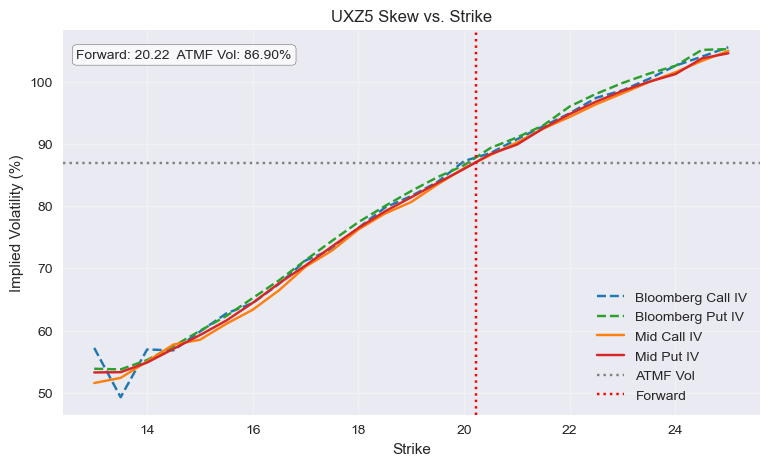

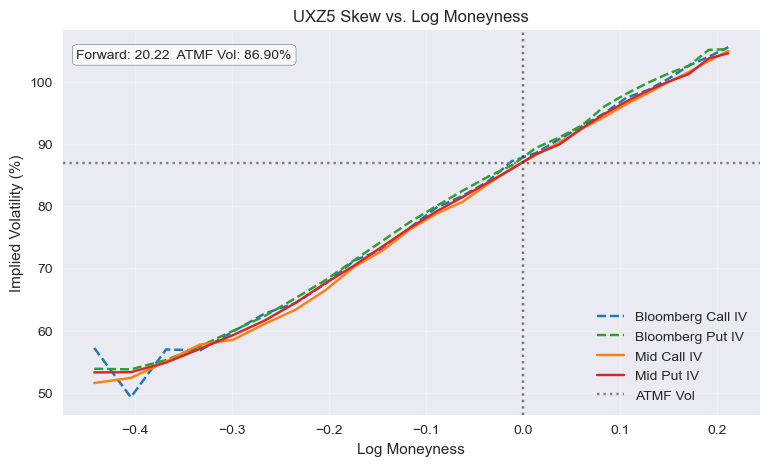

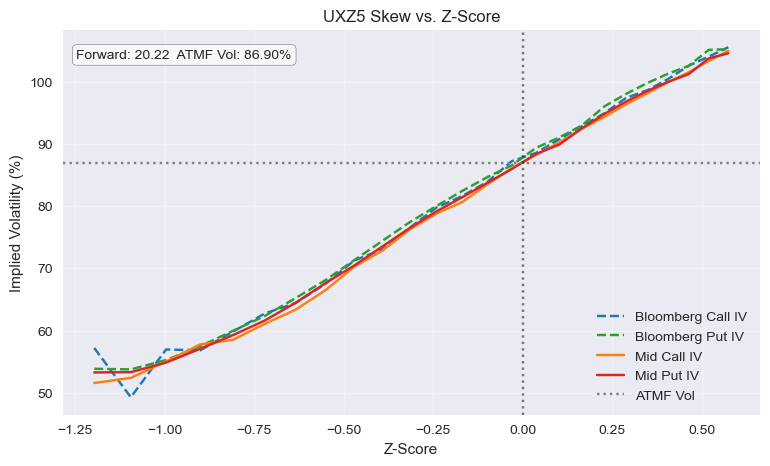

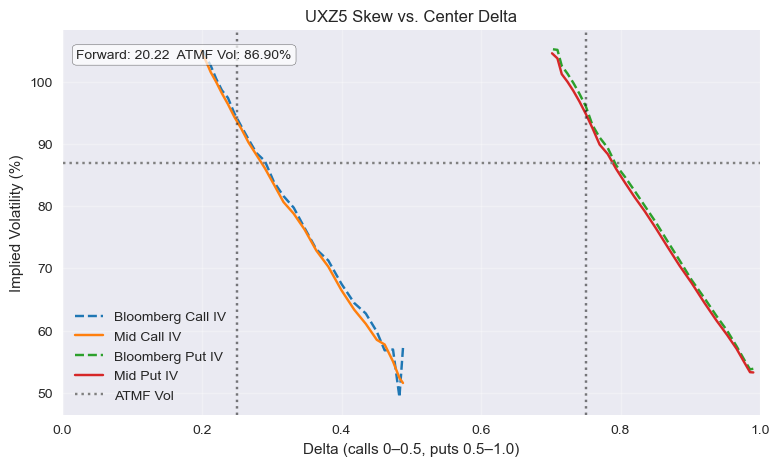

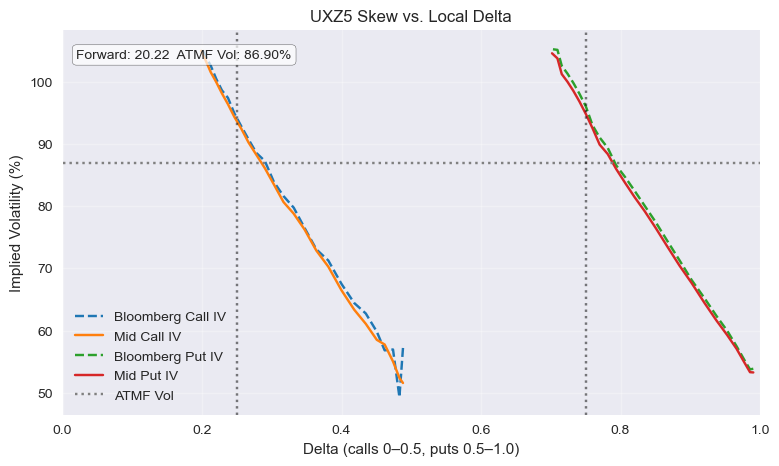

,Metric,Value
0,Forward (Parity Avg),21.051591
1,ATMF Vol,0.777216
2,ATM Call Delta,0.576249


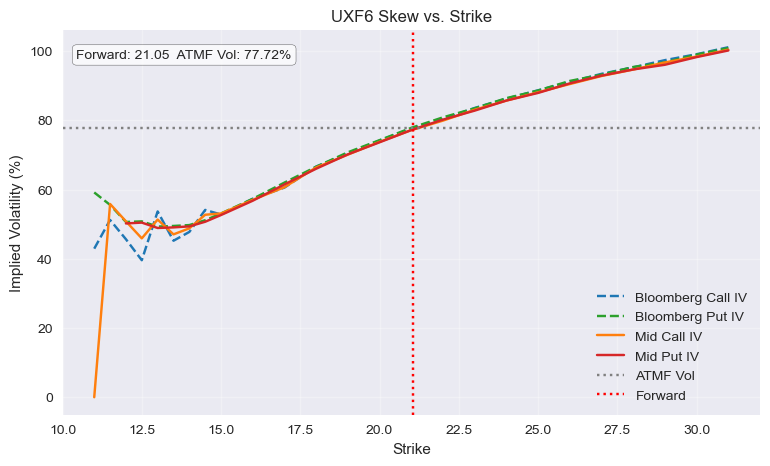

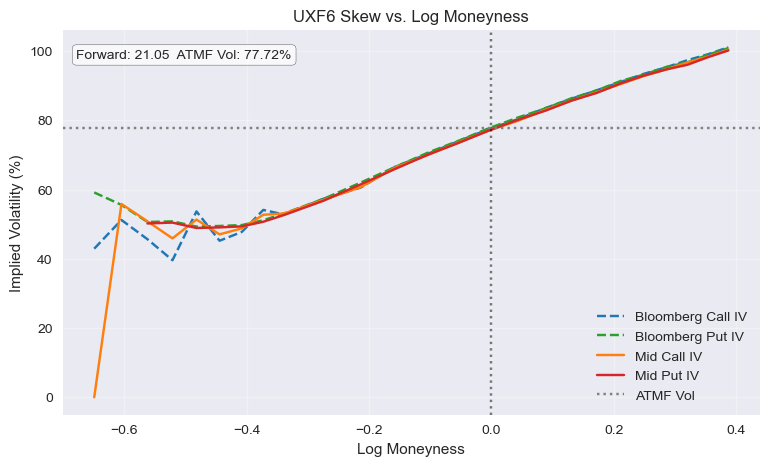

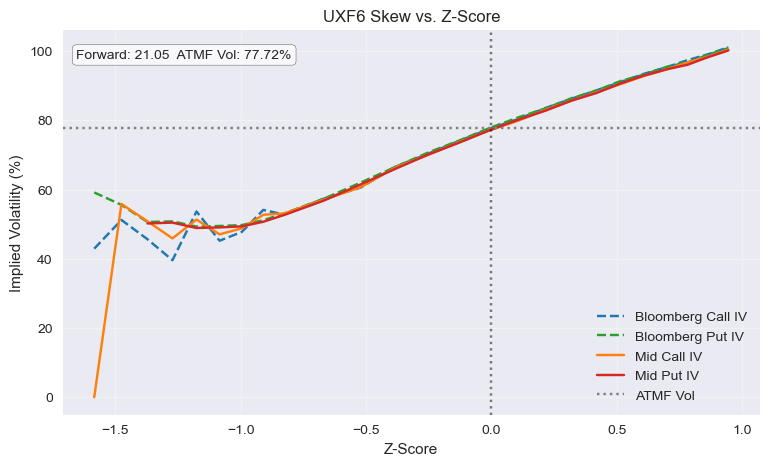

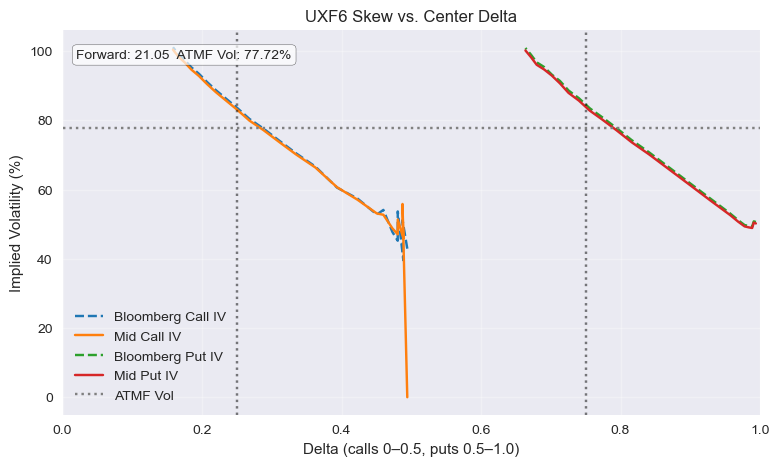

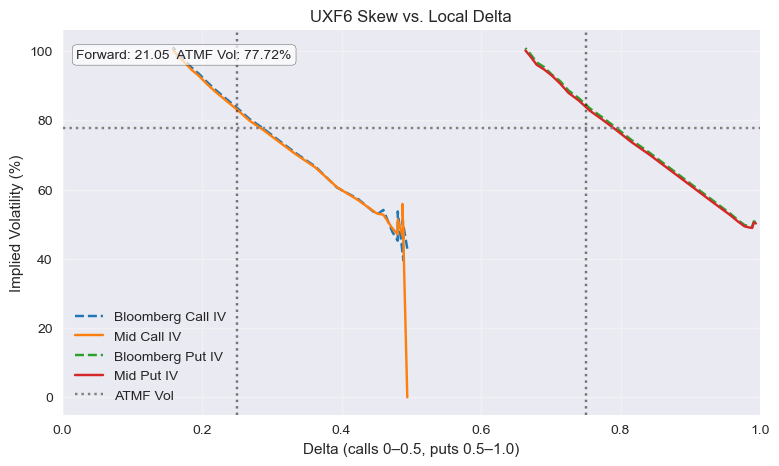

In [14]:

axis_config = [
    ('Strike', 'Strike'),
    ('Log Moneyness', 'Log Moneyness'),
    ('Z-Score', 'Z-Score'),
    ('Center Delta', 'Center Delta'),
    ('Local Delta', 'Local Delta'),
]

for expiry in ['UXZ5', 'UXF6']:
    grp = expiry_results[expiry].sort_values('Strike').copy()
    rate = grp['r'].iloc[0]
    tenor = grp['T'].iloc[0]
    forward_level = grp['Forward Level'].iloc[0]
    atmf_vol = grp['ATMFVol'].iloc[0]
    atm_delta = grp['ATM Call Delta'].iloc[0]

    display(pd.DataFrame({'Metric': ['Forward (Parity Avg)', 'ATMF Vol', 'ATM Call Delta'],
                            'Value': [forward_level, atmf_vol, atm_delta]}))

    for axis_label, axis_col in axis_config:
        # --- Step 5: Prepare data subsets, dropping NaNs ---
        calls_ok = grp[['DeltaX_call', 'Mid Call IV', 'Bloomberg Call IV']].dropna()
        puts_ok  = grp[['DeltaX_put',  'Mid Put IV',  'Bloomberg Put IV']].dropna()

        # --- Delta-based plots ---
        if axis_col in ['Center Delta', 'Local Delta']:
            fig, ax = plt.subplots(figsize=(9, 5))
            # Use the mapped delta axes and filtered data
            ax.plot(calls_ok['DeltaX_call'], calls_ok['Bloomberg Call IV']*100, '--', label='Bloomberg Call IV', color='tab:blue')
            ax.plot(calls_ok['DeltaX_call'], calls_ok['Mid Call IV']*100, '-', label='Mid Call IV', color='tab:orange')
            ax.plot(puts_ok['DeltaX_put'], puts_ok['Bloomberg Put IV']*100, '--', label='Bloomberg Put IV', color='tab:green')
            ax.plot(puts_ok['DeltaX_put'], puts_ok['Mid Put IV']*100, '-', label='Mid Put IV', color='tab:red')

            ax.axhline(atmf_vol*100, color='gray', linestyle=':', label='ATMF Vol')
            ax.axvline(0.25, color='black', linestyle=':', alpha=0.5)
            ax.axvline(0.75, color='black', linestyle=':', alpha=0.5)
            ax.set_xlim(0, 1)
            ax.set_xlabel('Delta (calls 0–0.5, puts 0.5–1.0)')

        # --- Strike / Log Moneyness / Z-Score plots ---
        else:
            fig, ax = plt.subplots(figsize=(9, 5))
            x = grp[axis_col]
            ax.plot(x, grp['Bloomberg Call IV']*100, '--', label='Bloomberg Call IV', color='tab:blue')
            ax.plot(x, grp['Bloomberg Put IV']*100, '--', label='Bloomberg Put IV', color='tab:green')
            ax.plot(x, grp['Mid Call IV']*100, '-', label='Mid Call IV', color='tab:orange')
            ax.plot(x, grp['Mid Put IV']*100, '-', label='Mid Put IV', color='tab:red')

            # Reference lines
            ax.axhline(atmf_vol*100, color='gray', linestyle=':', label='ATMF Vol')
            if axis_col == 'Strike':
                ax.axvline(forward_level, color='red', linestyle=':', label='Forward')
            elif axis_col == 'Log Moneyness':
                ax.axvline(0.0, color='black', linestyle=':', alpha=0.5)
            elif axis_col == 'Z-Score':
                ax.axvline(0.0, color='black', linestyle=':', alpha=0.5)
            ax.set_xlabel(axis_label)

        # --- Common formatting ---
        ax.set_title(f"{expiry} Skew vs. {axis_label}")
        ax.set_ylabel('Implied Volatility (%)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.annotate(f"Forward: {forward_level:.2f}  ATMF Vol: {atmf_vol:.2%}",
                    xy=(0.02, 0.95), xycoords='axes fraction',
                    ha='left', va='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        plt.show()



### Skew Interpretation

| Expiry | Axis / Plot Type | Forward (F) | ATMF Vol (%) | Observed Skew Shape | Comparison of Skews (A–D) | Interpretation |
|:-------|:-----------------|-------------:|--------------:|:--------------------|:---------------------------|:---------------|
| **UXZ5 (17 Dec 2025)** | **Strike (K)** | 20.22 | 86.9 | Strong downward slope (vol ↑ as strike ↓) | All 4 curves closely aligned; Bloomberg slightly higher near wings | downside skew: front-month VIX options price high vol for low strikes → demand for volatility protection. |
| | **Log Moneyness ln(K/F)** | 20.22 | 86.9 | Linear, negative slope | Near-identical A–D behavior | Confirms skew symmetry in log space; at-the-money forward marks transition from high-vol puts to lower-vol calls. |
| | **Z-Score** | 20.22 | 86.9 | Smooth monotonic decay | Slight Bloomberg uplift in deep wings | Z-score normalization shows continuous surface—vol declines ≈ 15 vol pts per σ. |
| | **Center Δ** | 20.22 | 86.9 | Decreasing from Δ ≈ 0.2→0.8 | Tight overlap across all 4; calls (≤ 0.5) vs puts (> 0.5) clearly separated | Proper 0–1 Δ mapping achieved; shows symmetric slope about ATM; steep front-month skew. |
| | **Local Δ** | 20.22 | 86.9 | Similar to Center Δ | Vertical lines at 0.25/0.75 visible | Confirms short-dated options highly sensitive to Δ; near-ATM vols consistent across data sources. |
| **UXF6 (21 Jan 2026)** | **Strike (K)** | 21.05 | 77.7 | Flatter curve, mild decline with strike | A–D nearly coincident | **Flatter back-month skew**: less event risk after year-end; lower overall vol. |
| | **Log Moneyness ln(K/F)** | 21.05 | 77.7 | Gentle negative slope | Mid vols match Bloomberg precisely | Implies consistent vol surface, little curvature around ATM. |
| | **Z-Score** | 21.05 | 77.7 | Smooth, nearly linear | Bloomberg wings marginally higher | Term-structure smoothing: far-month volatility more symmetric. |
| | **Center Δ** | 21.05 | 77.7 | Almost linear decline | Four skews collapse together | Δ-based view highlights muted asymmetry; far-OTM quotes less extreme than Dec contract. |
| | **Local Δ** | 21.05 | 77.7 | Flat through 0.25–0.75 range | Vertical guides at 0.25 and 0.75 present | Confirms low curvature and consistent delta mapping; validates proper 0–1 axis construction. |

**Overall Summary:**  
The December (UXZ5) expiry exhibits **higher volatility and a steeper negative skew**, consistent with short-term VIX risk premia.  
The January (UXF6) expiry shows **lower ATMF volatility and flatter skew**, reflecting normalization of expected volatility.  
Across all 10 plots, Bloomberg indicative and mid-price implied volatilities align closely, verifying both data quality and accurate Black-76 inversion.


In [13]:

comparison = []
for expiry, grp in expiry_results.items():
    comparison.append({
        'Expiry': expiry,
        'Forward (Parity Avg)': grp['Forward Level'].iloc[0],
        'Future Reference': grp['Future'].iloc[0],
        'ATMF Vol': grp['ATMFVol'].iloc[0],
        'ATM Call Delta': grp['ATM Call Delta'].iloc[0]
    })
summary_table = pd.DataFrame(comparison)
summary_table


,Expiry,Forward (Parity Avg),Future Reference,ATMF Vol,ATM Call Delta
0,UXF6,21.051591,21.08,0.777216,0.576249
1,UXZ5,20.223022,20.26,0.868952,0.580251


The parity-derived forwards track the quoted futures within a few basis points for both expiries, validating the time-to-expiry alignment with the 13 October 2025 valuation date. UXZ5 carries the lower forward level and a higher ATMF volatility, reflecting nearer-term event risk and a steeper downside skew. UXF6 forwards sit higher with slightly lower ATMF volatility, and its skew profile is comparatively muted, indicating calmer expectations further along the curve.